In [1]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


# ---------------- 1. 数据准备 ----------------
item2idx = {'牛奶': 0, '面包': 1, '鸡蛋': 2, '啤酒': 3, '尿布': 4}
idx2item = {v: k for k, v in item2idx.items()}

# 三条示例购买序列
sequences = [
    ['牛奶', '面包', '鸡蛋'],
    ['啤酒', '尿布', '牛奶'],
    ['鸡蛋', '面包', '啤酒'],
]

def generate_positive_pairs(seqs, window_size=1):
    """滑动窗口生成 Skip-gram 正样本 (center, context)。"""
    pairs = []
    for seq in seqs:
        ids = [item2idx[i] for i in seq]
        for center in range(len(ids)):
            for offset in range(-window_size, window_size + 1):
                if offset == 0:
                    continue
                pos = center + offset
                if 0 <= pos < len(ids):
                    pairs.append((ids[center], ids[pos]))
    return pairs

pairs = generate_positive_pairs(sequences, window_size=1)

# ---------------- 2. Item2Vec 模型 ----------------
class Item2Vec(nn.Module):
    def __init__(self, vocab_size: int, embed_dim: int):
        super().__init__()
        self.in_embed = nn.Embedding(vocab_size, embed_dim)   # 中心向量表
        self.out_embed = nn.Embedding(vocab_size, embed_dim)  # 上下文向量表

    def forward(self, center, context, negatives):
        """
        center:   (B,)
        context:  (B,)
        negatives:(B, K)
        """
        center_vec = self.in_embed(center)                      # (B, D)
        pos_vec    = self.out_embed(context)                    # (B, D)
        neg_vec    = self.out_embed(negatives)                  # (B, K, D)

        # 正样本得分   (B,)
        pos_score = torch.sum(center_vec * pos_vec, dim=1)

        # 负样本得分   (B, K):  bmm -> (B,1,K)-> squeeze
        neg_score = torch.bmm(neg_vec, center_vec.unsqueeze(2)).squeeze(dim=2)

        # Skip-gram NS 损失
        loss_pos = F.logsigmoid(pos_score)                      # want → 0
        loss_neg = F.logsigmoid(-neg_score).sum(dim=1)          # want → 0
        loss = -(loss_pos + loss_neg).mean()
        return loss

# ---------------- 3. 训练 ----------------
VOCAB_SIZE = len(item2idx)
EMBED_DIM  = 40          
NEG_K      = 3          # 每个中心取 3 个负样本
EPOCHS     = 100
LR         = 0.05
BATCH_SIZE = 8
random.seed(42)
torch.manual_seed(42)

model = Item2Vec(VOCAB_SIZE, EMBED_DIM)
opt = torch.optim.Adam(model.parameters(), lr=LR)

def get_batch(pairs, batch_size):
    """简单随机批采样生成 (center, context, negatives)。"""
    batch = random.sample(pairs, batch_size)
    center  = torch.tensor([c for c, _ in batch])
    context = torch.tensor([o for _, o in batch])

    # 负采样，确保不与正样本冲突
    negs = []
    vocab = list(range(VOCAB_SIZE))
    for (_, o) in batch:
        cur_neg = []
        while len(cur_neg) < NEG_K:
            neg = random.choice(vocab)
            if neg != o:
                cur_neg.append(neg)
        negs.append(cur_neg)
    negatives = torch.tensor(negs)  # (B, K)
    return center, context, negatives

for epoch in range(EPOCHS):
    total_loss = 0.0
    num_steps  = max(len(pairs) // BATCH_SIZE, 1)
    for _ in range(num_steps):
        c, o, n = get_batch(pairs, BATCH_SIZE)
        loss = model(c, o, n)
        opt.zero_grad()
        loss.backward()
        opt.step()
        total_loss += loss.item()
    if epoch % 10 == 0:
        print(f'Epoch {epoch:03d} | Loss {total_loss/num_steps:.4f}')



Epoch 000 | Loss 11.2976
Epoch 010 | Loss 0.8899
Epoch 020 | Loss 1.8705
Epoch 030 | Loss 1.2554
Epoch 040 | Loss 0.9699
Epoch 050 | Loss 1.0543
Epoch 060 | Loss 1.3987
Epoch 070 | Loss 1.5097
Epoch 080 | Loss 1.2485
Epoch 090 | Loss 1.2492


In [2]:
with torch.no_grad():
    emb = model.in_embed.weight  # (V, D)
    cos = F.cosine_similarity(emb[0], emb[1], dim=0)  # 牛奶 vs 面包
    print("cos(牛奶, 面包) =", cos.item())


cos(牛奶, 面包) = 0.08432582020759583


In [3]:
with torch.no_grad():
    emb = model.in_embed.weight
    for i in range(VOCAB_SIZE):
        for j in range(VOCAB_SIZE):
            sim = F.cosine_similarity(emb[i], emb[j], dim=0).item()
            print(f"cos({idx2item[i]}, {idx2item[j]}) = {sim:.3f}")


cos(牛奶, 牛奶) = 1.000
cos(牛奶, 面包) = 0.084
cos(牛奶, 鸡蛋) = 0.012
cos(牛奶, 啤酒) = 0.358
cos(牛奶, 尿布) = -0.051
cos(面包, 牛奶) = 0.084
cos(面包, 面包) = 1.000
cos(面包, 鸡蛋) = 0.061
cos(面包, 啤酒) = 0.097
cos(面包, 尿布) = 0.029
cos(鸡蛋, 牛奶) = 0.012
cos(鸡蛋, 面包) = 0.061
cos(鸡蛋, 鸡蛋) = 1.000
cos(鸡蛋, 啤酒) = 0.101
cos(鸡蛋, 尿布) = -0.148
cos(啤酒, 牛奶) = 0.358
cos(啤酒, 面包) = 0.097
cos(啤酒, 鸡蛋) = 0.101
cos(啤酒, 啤酒) = 1.000
cos(啤酒, 尿布) = -0.085
cos(尿布, 牛奶) = -0.051
cos(尿布, 面包) = 0.029
cos(尿布, 鸡蛋) = -0.148
cos(尿布, 啤酒) = -0.085
cos(尿布, 尿布) = 1.000


In [4]:
import random

# 固定 vocab
item2idx = {
    '牛奶': 0, '面包': 1, '鸡蛋': 2, '啤酒': 3, '尿布': 4,
    '可乐': 5, '爆米花': 6, '方便面': 7, '洗衣液': 8, '牙刷': 9
}
idx2item = {v: k for k, v in item2idx.items()}
VOCAB_SIZE = len(item2idx)

# 创建用户行为数据（每类用户偏好不同组合）
def generate_user_sequences(num_users=30):
    sequences = []
    for _ in range(num_users):
        # 随机选用户类型
        user_type = random.choice(['早餐型', '啤酒型', '宅家型'])
        seq = []
        if user_type == '早餐型':
            seq = random.sample(['牛奶', '面包', '鸡蛋'], k=3)
        elif user_type == '啤酒型':
            seq = random.sample(['啤酒', '尿布', '爆米花'], k=3)
        elif user_type == '宅家型':
            seq = random.sample(['方便面', '可乐', '洗衣液', '牙刷'], k=3)
        # 加入到序列集合
        sequences.append(seq)
    return sequences

# 替换旧数据
sequences = generate_user_sequences(num_users=30)


In [5]:
def generate_positive_pairs(seqs, window_size=1):
    """滑动窗口生成 Skip-gram 正样本 (center, context)。"""
    pairs = []
    for seq in seqs:
        ids = [item2idx[i] for i in seq]
        for center in range(len(ids)):
            for offset in range(-window_size, window_size + 1):
                if offset == 0:
                    continue
                pos = center + offset
                if 0 <= pos < len(ids):
                    pairs.append((ids[center], ids[pos]))
    return pairs

pairs = generate_positive_pairs(sequences, window_size=1)

# ---------------- 2. Item2Vec 模型 ----------------
class Item2Vec(nn.Module):
    def __init__(self, vocab_size: int, embed_dim: int):
        super().__init__()
        self.in_embed = nn.Embedding(vocab_size, embed_dim)   # 中心向量表
        self.out_embed = nn.Embedding(vocab_size, embed_dim)  # 上下文向量表

    def forward(self, center, context, negatives):
        """
        center:   (B,)
        context:  (B,)
        negatives:(B, K)
        """
        center_vec = self.in_embed(center)                      # (B, D)
        pos_vec    = self.out_embed(context)                    # (B, D)
        neg_vec    = self.out_embed(negatives)                  # (B, K, D)

        # 正样本得分   (B,)
        pos_score = torch.sum(center_vec * pos_vec, dim=1)

        # 负样本得分   (B, K):  bmm -> (B,1,K)-> squeeze
        neg_score = torch.bmm(neg_vec, center_vec.unsqueeze(2)).squeeze(dim=2)

        # Skip-gram NS 损失
        loss_pos = F.logsigmoid(pos_score)                      # want → 0
        loss_neg = F.logsigmoid(-neg_score).sum(dim=1)          # want → 0
        loss = -(loss_pos + loss_neg).mean()
        return loss

# ---------------- 3. 训练 ----------------
VOCAB_SIZE = len(item2idx)
EMBED_DIM  = 40          
NEG_K      = 3          # 每个中心取 3 个负样本
EPOCHS     = 100
LR         = 0.05
BATCH_SIZE = 8
random.seed(42)
torch.manual_seed(42)

model = Item2Vec(VOCAB_SIZE, EMBED_DIM)
opt = torch.optim.Adam(model.parameters(), lr=LR)

def get_batch(pairs, batch_size):
    """简单随机批采样生成 (center, context, negatives)。"""
    batch = random.sample(pairs, batch_size)
    center  = torch.tensor([c for c, _ in batch])
    context = torch.tensor([o for _, o in batch])

    # 负采样，确保不与正样本冲突
    negs = []
    vocab = list(range(VOCAB_SIZE))
    for (_, o) in batch:
        cur_neg = []
        while len(cur_neg) < NEG_K:
            neg = random.choice(vocab)
            if neg != o:
                cur_neg.append(neg)
        negs.append(cur_neg)
    negatives = torch.tensor(negs)  # (B, K)
    return center, context, negatives

for epoch in range(EPOCHS):
    total_loss = 0.0
    num_steps  = max(len(pairs) // BATCH_SIZE, 1)
    for _ in range(num_steps):
        c, o, n = get_batch(pairs, BATCH_SIZE)
        loss = model(c, o, n)
        opt.zero_grad()
        loss.backward()
        opt.step()
        total_loss += loss.item()
    if epoch % 10 == 0:
        print(f'Epoch {epoch:03d} | Loss {total_loss/num_steps:.4f}')



Epoch 000 | Loss 4.4648
Epoch 010 | Loss 1.0575
Epoch 020 | Loss 1.0571
Epoch 030 | Loss 1.0476
Epoch 040 | Loss 1.1300
Epoch 050 | Loss 1.0866
Epoch 060 | Loss 1.1644
Epoch 070 | Loss 1.0184
Epoch 080 | Loss 1.0331
Epoch 090 | Loss 0.9518


In [7]:
with torch.no_grad():
    emb = model.in_embed.weight
    for i in range(VOCAB_SIZE):
        for j in range(i + 1, VOCAB_SIZE):
            sim = F.cosine_similarity(emb[i], emb[j], dim=0).item()
            if sim > 0.3:  # 过滤弱关系
                print(f"{idx2item[i]} <-> {idx2item[j]} : {sim:.3f}")


牛奶 <-> 面包 : 0.321
牛奶 <-> 鸡蛋 : 0.340
啤酒 <-> 尿布 : 0.356
啤酒 <-> 爆米花 : 0.556
尿布 <-> 爆米花 : 0.421
可乐 <-> 方便面 : 0.469
可乐 <-> 洗衣液 : 0.534
可乐 <-> 牙刷 : 0.472
方便面 <-> 洗衣液 : 0.494
方便面 <-> 牙刷 : 0.656
洗衣液 <-> 牙刷 : 0.346


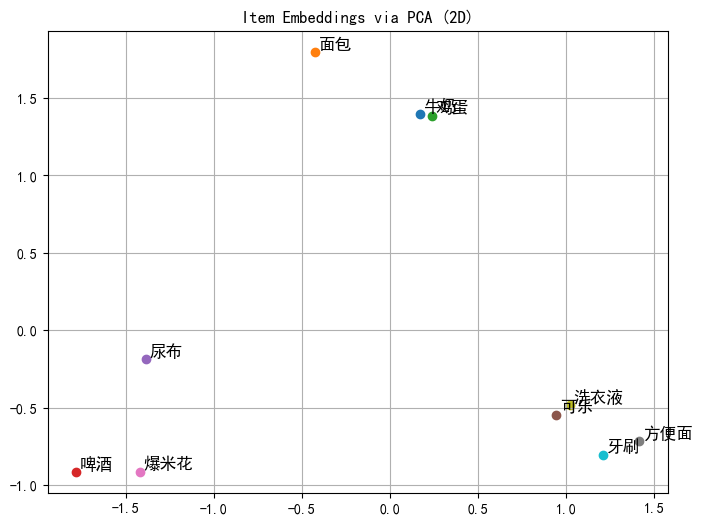

In [9]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 设置中文字体
plt.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

# 获取 embedding
embeddings = model.in_embed.weight.detach().numpy()
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(embeddings)

# 绘图
plt.figure(figsize=(8, 6))
for idx, (x, y) in enumerate(emb_2d):
    plt.scatter(x, y)
    plt.text(x + 0.02, y + 0.02, idx2item[idx], fontsize=12)
plt.title("Item Embeddings via PCA (2D)")
plt.grid(True)
plt.show()



In [10]:
def top_k_similar(item_name, topk=3):
    from torch.nn.functional import cosine_similarity
    idx = item2idx[item_name]
    v = model.in_embed.weight[idx]
    sims = cosine_similarity(v.unsqueeze(0), model.in_embed.weight).detach().numpy()
    top_indices = sims.argsort()[::-1][1:topk+1]
    return [(idx2item[i], sims[i]) for i in top_indices]

print(top_k_similar("啤酒"))


[('爆米花', 0.55594903), ('尿布', 0.3558503), ('可乐', 0.2174432)]
